In [12]:
import os

import librosa
import numpy as np
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import librosa.display
from pathlib import Path
from IPython import display as disp
import matplotlib.pyplot as plt

In [3]:
def get_files(d):
    return [Path(f'{d}/{f}').as_posix() for f in os.listdir(d)]

In [79]:
files = get_files('/mnt/data/MS-SNSD/NoisySpeech_training/')

In [38]:
len(files)

3055

In [82]:
from sklearn.model_selection import train_test_split

train_files, test_files = train_test_split(files, test_size=0.2)

In [91]:
def make_annotation(files, noisy_dir='NoisySpeech_training', clean_dir='CleanSpeech_training'):
    s = ''
    root = '/'.join(files[0].split('/')[:-2]) 
    for f in files:
        name = f.split('_')[-1]
        s += f + ' ' + f'{root}/{clean_dir}/{name}' + '\n'
    return s

In [100]:
train_ann = make_annotation(train_files)
test_ann = make_annotation(test_files)

In [101]:
rows = test_ann.split('\n')

In [102]:
row = np.random.choice(rows)
noisy_path, clean_path = row.split()
disp.display(disp.Audio(noisy_path))
disp.display(disp.Audio(clean_path))

In [103]:
# with open('/home/worker/workspace/audio/denoiser/wave_wizard/dataset/train.txt', 'w') as f:
#     f.write(train_ann)

# with open('/home/worker/workspace/audio/denoiser/wave_wizard/dataset/val.txt', 'w') as f:
#     f.write(test_ann)    

In [4]:
def sample_fixed_length_data_aligned(data_a, data_b, sample_len):
    """sample with fixed length from two dataset"""
    assert len(data_a) == len(
        data_b
    ), "Inconsistent dataset length, unable to sampling"
    assert (
        len(data_a) >= sample_len
    ), f"len(data_a) is {len(data_a)}, sample_len is {sample_len}."

    frames_total = len(data_a)
    start = np.random.randint(frames_total - sample_len + 1)
    end = start + sample_len

    return data_a[start:end], data_b[start:end]

In [5]:
def plot_waveform(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    return librosa.display.waveshow(wav, sr=sr, ax=ax)

def plot_mel(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    S = librosa.feature.melspectrogram(y=wav, sr=sr)
    return librosa.display.specshow(librosa.power_to_db(S, ref=np.max), ax=ax)

In [15]:
class AudioSet(Dataset):
    def __init__(
        self,
        file_path,
        sample_len=16384,
        mode="train",
        shift=0,
    ):
        super(Dataset, self).__init__()
        dataset_list = [
            line.rstrip("\n").rstrip()
            for line in open(
                os.path.abspath(os.path.expanduser(file_path)), "r"
            )
        ]

        assert mode in ("train", "val")
        
        self.length = len(dataset_list)
        self.dataset_list = dataset_list
        self.sample_len = sample_len + shift
        self.mode = mode

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        noisy_path, clean_path  = self.dataset_list[i].split(" ")
        filename = os.path.splitext(os.path.basename(noisy_path))[0]
        noisy, _ = librosa.load(
            os.path.abspath(os.path.expanduser(noisy_path)), sr=None
        )

        clean, _ = librosa.load(
            os.path.abspath(os.path.expanduser(clean_path)), sr=None
        )

        assert len(clean) == len(noisy)

        if self.mode == "train":
            # The input of model should be fixed-length in the training.
            noisy, clean = sample_fixed_length_data_aligned(
                noisy, clean, self.sample_len
            )
            return noisy.reshape(1, -1), clean.reshape(1, -1), filename
        else:
            return noisy.reshape(1, -1), clean.reshape(1, -1), filename


In [16]:
def get_train_val_loaders(config):
    val_loader = None
    train_set = AudioSet(file_path=config['train']['ann_path'],
                         sample_len=config['sample_len'],
                         mode='train',
                         shift=config['shift'],
                         )
    train_loader = DataLoader(train_set, **config['train']['dataloader'])
    if 'val' in config:
        val_set = AudioSet(file_path=config['train']['ann_path'],
                           sample_len=config['sample_len'],
                           mode='val',
                           shift=config['shift'],
                        )
        val_loader = DataLoader(val_set, **config['val']['dataloader'])

    return train_loader, val_loader

In [17]:
import yaml
import sys
sys.path.append('..')
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

In [18]:
train_loader, val_loader = get_train_val_loaders(config['dataset'])

In [19]:
for noisy, clean, name in train_loader:
    break

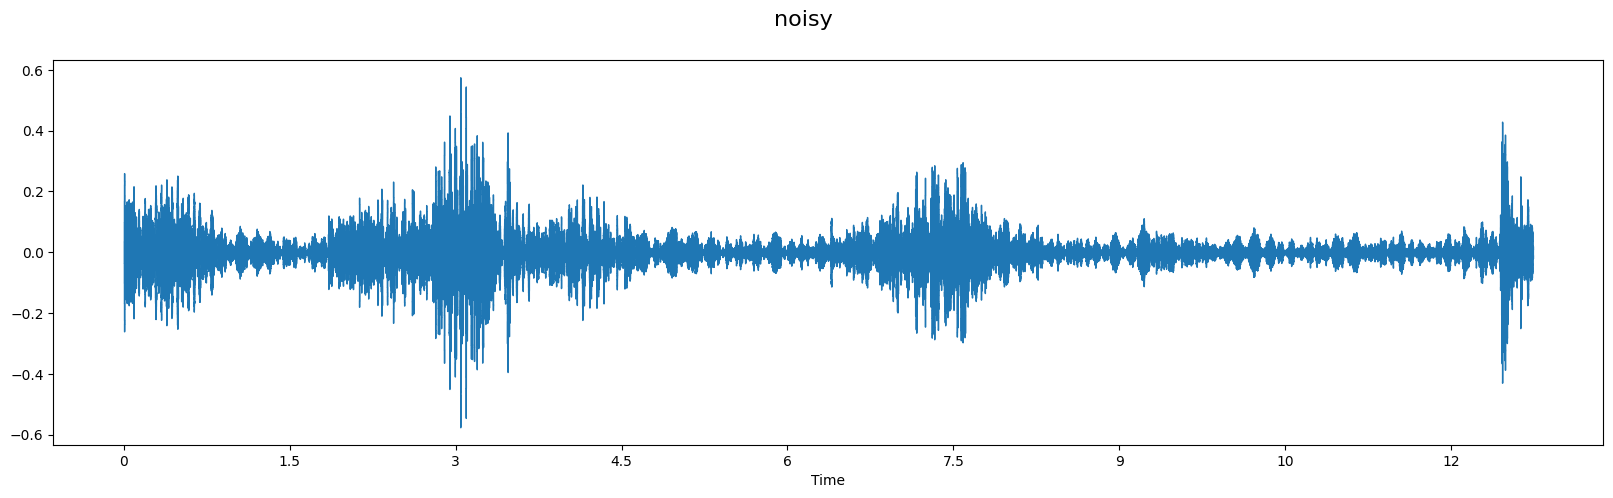

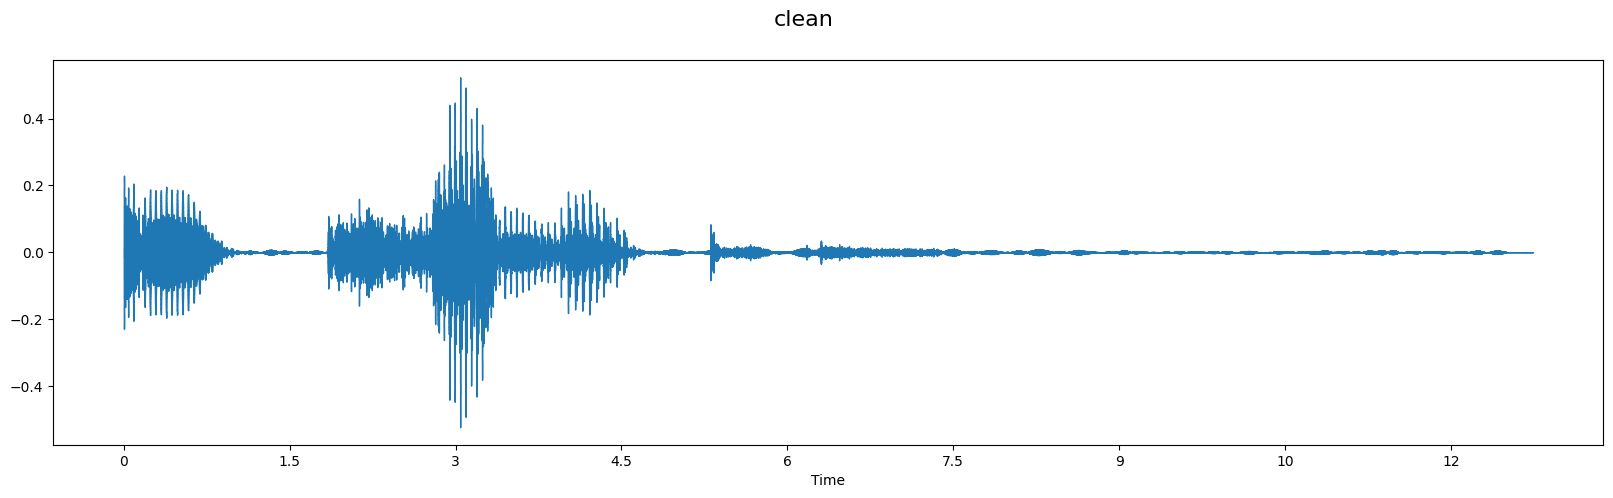

In [20]:
plot_waveform(noisy.numpy()[0], 1600, label='noisy')
plot_waveform(clean.numpy()[0], 1600, label='clean')